<a href="https://colab.research.google.com/github/kkorolev1/dl-1/blob/master/hw/shw_02_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

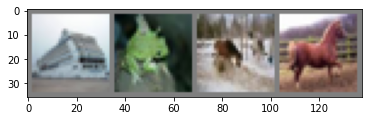

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.num_out_channels = 32
        self.pooling_size = 4
        self.fc_input_size = self.pooling_size * self.pooling_size * self.num_out_channels

        self.block_head = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.num_out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.num_out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.num_out_channels, out_channels=self.num_out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.num_out_channels)
        )

        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=self.num_out_channels, kernel_size=1)
        self.block_end = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(self.num_out_channels // self.pooling_size)
        )

        self.fc = nn.Linear(in_features=self.fc_input_size, out_features=n_classes)

    def forward(self, x):
        out = self.block_head(x) + self.conv1x1(x)
        out = self.block_end(out)
        out = self.fc(out.reshape(x.shape[0], self.fc_input_size))
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block_head): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (block_end): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [24]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [9]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        out = model(data)
        loss = criterion(out, target)

        loss_log.append(loss.item())
        
        acc = (torch.argmax(out, dim=1) == target).sum() / target.shape[0]
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out, target)
        
        loss_log.append(loss.item())
        
        loss.backward()
        optimizer.step()

        acc = (torch.argmax(out, dim=1) == target).sum() / target.shape[0]

        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.464003577637716, train acc: 0.47932309359039643
 val loss: 1.211027594069217, val acc: 0.5679521276595745

Epoch 1
 train loss: 1.157344567383447, train acc: 0.5930236354606461
 val loss: 1.1471746059174233, val acc: 0.6048758866939139

Epoch 2
 train loss: 1.0444879721461964, train acc: 0.6388376534965836
 val loss: 1.0787593450952084, val acc: 0.6286125888215734

Epoch 3
 train loss: 0.986213649648635, train acc: 0.6571518347293847
 val loss: 1.0290301297573332, val acc: 0.6449468085106383

Epoch 4
 train loss: 0.9503070664144303, train acc: 0.6704875620889054
 val loss: 0.9951426062178105, val acc: 0.6537898936170212

Epoch 5
 train loss: 0.9267621451147732, train acc: 0.6780572604435672
 val loss: 0.9757163268454532, val acc: 0.6657136526513607

Epoch 6
 train loss: 0.9002570964300655, train acc: 0.6877325999889339
 val loss: 1.0451726101814431, val acc: 0.6450576241980208

Epoch 7
 train loss: 0.8817485929407193, train acc: 0.6938862954240831
 val loss: 0.94

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8826429965389762, test acc: 0.6969546178343949


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
train_loss_mean = []
train_acc_mean = []

for i in range(20):
    n = len(train_loader.dataset) // 64 + 1
    train_loss_mean.append(np.mean(train_loss_log[i*n: (i+1)*n]))
    train_acc_mean.append(np.mean(train_acc_log[i*n: (i+1)*n]))

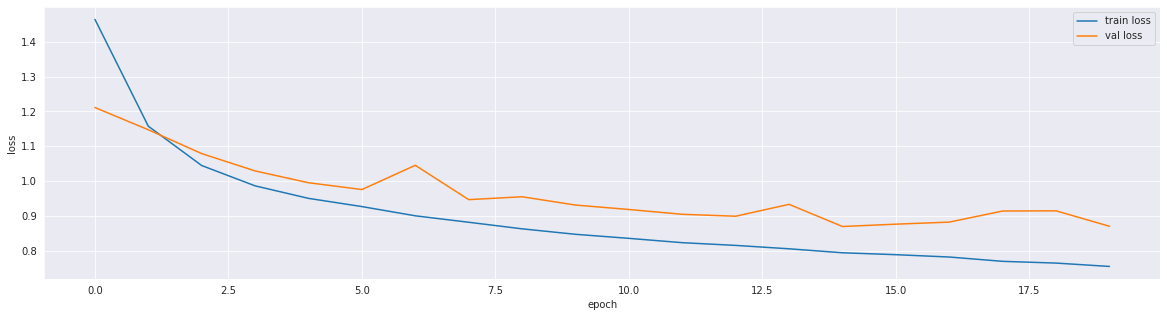

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=train_loss_mean)
sns.lineplot(data=val_loss_log)

plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

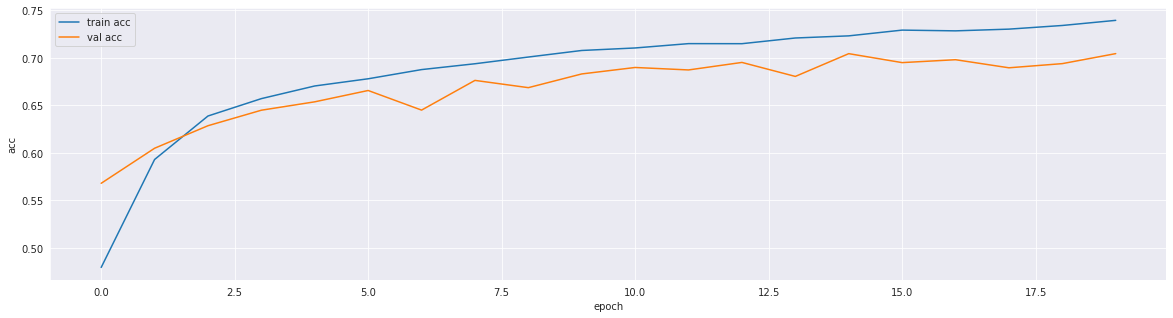

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=train_acc_mean)
sns.lineplot(data=val_acc_log)

plt.legend(['train acc', 'val acc'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4632555504603622, train acc: 0.4762992949328867
 val loss: 1.2113001453115586, val acc: 0.570567376055616

Epoch 1
 train loss: 1.1493778646101245, train acc: 0.5993364782394395
 val loss: 1.1238042636120573, val acc: 0.6111480497299356

Epoch 2
 train loss: 1.0532460427371413, train acc: 0.6317290742175017
 val loss: 1.0261070200737485, val acc: 0.6423980497299356

Epoch 3
 train loss: 0.9899536824531485, train acc: 0.6573558697099006
 val loss: 0.9781658834599434, val acc: 0.6601728723404255

Epoch 4
 train loss: 0.9436337211232299, train acc: 0.6741724341181558
 val loss: 0.9460393241111268, val acc: 0.6733599292471054

Epoch 5
 train loss: 0.9196571902775459, train acc: 0.6821950901796875
 val loss: 0.961407671329823, val acc: 0.6753989361702127

Epoch 6
 train loss: 0.8974738729065471, train acc: 0.6912256790907335
 val loss: 0.9610082859688617, val acc: 0.6648049646235527

Epoch 7
 train loss: 0.8776354808803014, train acc: 0.6965428310730776
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8167442988817859, test acc: 0.7226313694267515


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8364565518482077, train acc: 0.3586894424131627
 val loss: 1.615942218963136, val acc: 0.43477393617021276

Epoch 1
 train loss: 1.5422392817694264, train acc: 0.45851152394327865
 val loss: 1.4547930676886376, val acc: 0.4853723404255319

Epoch 2
 train loss: 1.4237224048844639, train acc: 0.49786987470316496
 val loss: 1.3689840154444917, val acc: 0.5189937944107867

Epoch 3
 train loss: 1.3576994572086787, train acc: 0.5247943327239488
 val loss: 1.3344982045762082, val acc: 0.5323359929500742

Epoch 4
 train loss: 1.30480201686758, train acc: 0.5422066793363317
 val loss: 1.2806125427814241, val acc: 0.5518838652904997

Epoch 5
 train loss: 1.2606828494961126, train acc: 0.5576113215094293
 val loss: 1.2405905226443676, val acc: 0.5616578014607125

Epoch 6
 train loss: 1.2191071047207556, train acc: 0.5731383847580096
 val loss: 1.2100279381934633, val acc: 0.5753102837724888

Epoch 7
 train loss: 1.1840046989634443, train acc: 0.5862700771370143
 val loss: 1

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.9761525586152532, test acc: 0.6548566878980892


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

### CosineAnnealingLR

CosineAnnealingLR is a scheduling technique that starts with a very large learning rate and then aggressively decreases it to a value near 0 before increasing the learning rate again.

Each time the “restart” occurs, we take the good weights from the previous “cycle” as the starting point. Thus, with each restart, the algorithm approaches the minimal loss closer.

Такое поведение достигается за счет периодичности косинуса.
https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html

![image-20221012-205910[1].webp](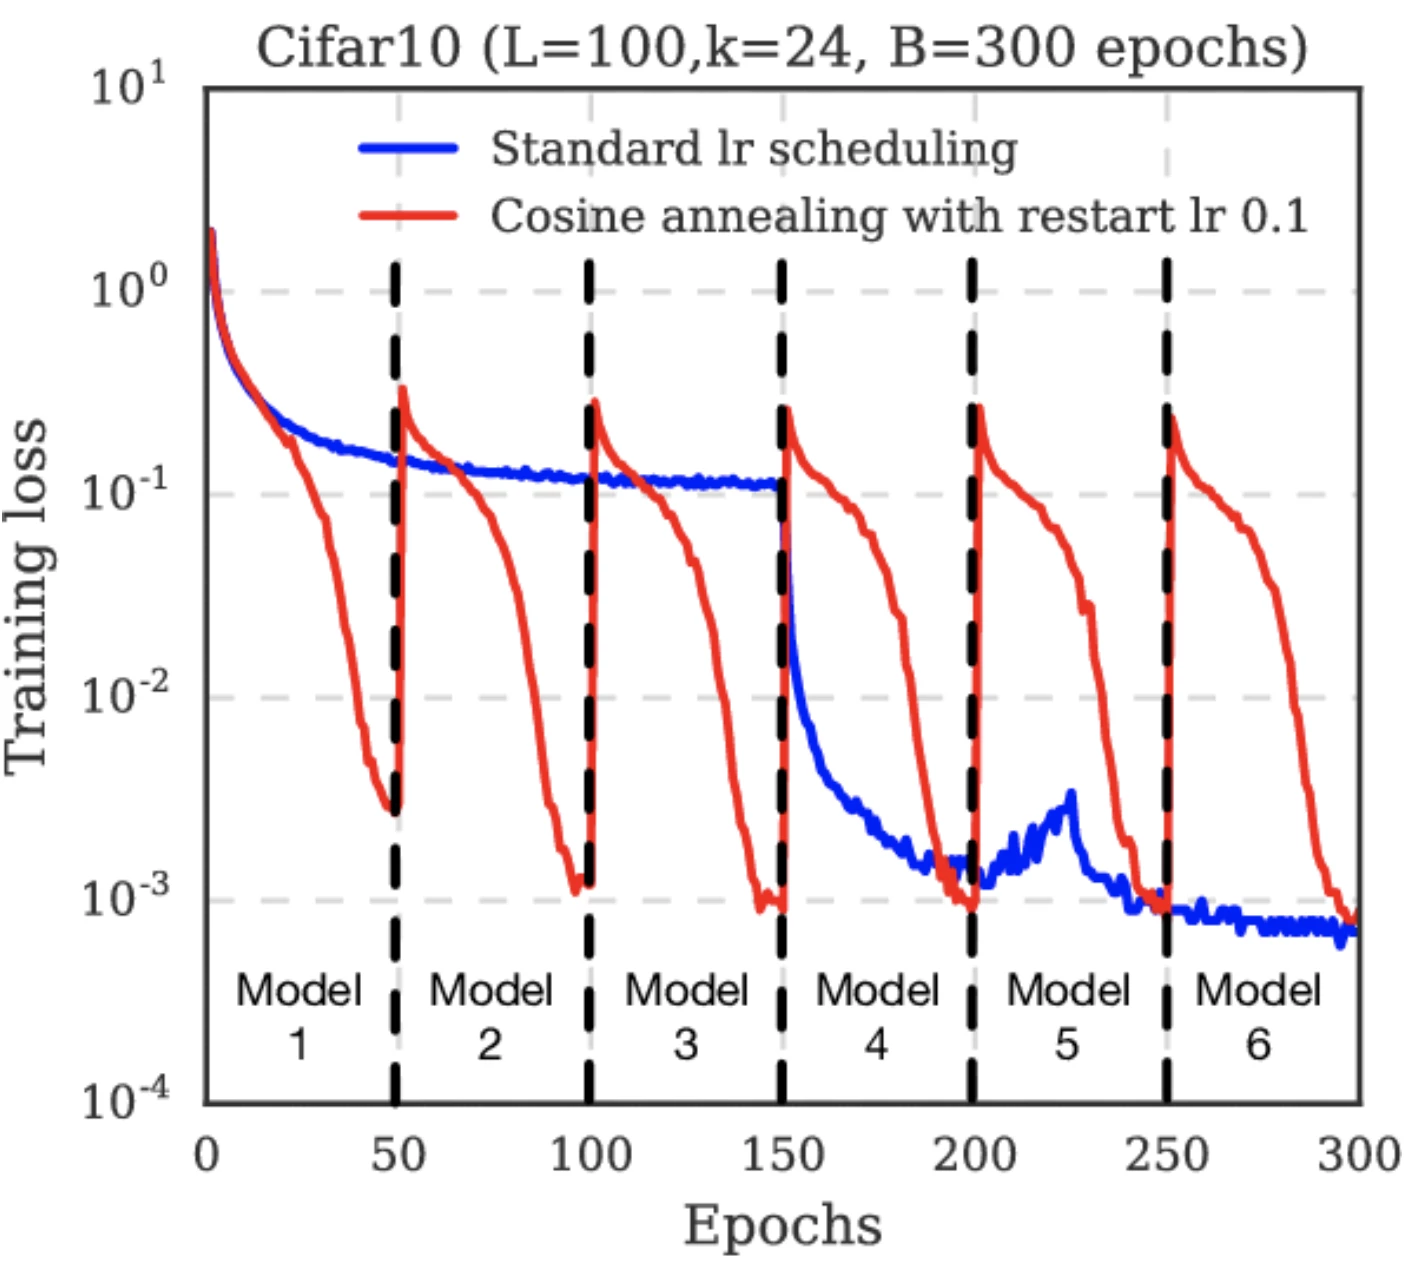)

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_acc_log))
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4867149645929145, train acc: 0.46982730481044904
 val loss: 1.2638335101147915, val acc: 0.5558510638297872

Epoch 1
 train loss: 1.173248670109883, train acc: 0.5899223034734917
 val loss: 1.173066024577364, val acc: 0.5933067377577437

Epoch 2
 train loss: 1.0451740670465681, train acc: 0.6357077566099777
 val loss: 1.0329904794692992, val acc: 0.6381205674181594

Epoch 3
 train loss: 0.9826832264389372, train acc: 0.6580659115118344
 val loss: 1.061432589875891, val acc: 0.6265957446808511

Epoch 4
 train loss: 0.9586313240488878, train acc: 0.6666435427160106
 val loss: 0.992200629254605, val acc: 0.6614804965384463

Epoch 5
 train loss: 0.9279114994096146, train acc: 0.6783510708067927
 val loss: 1.00258412361145, val acc: 0.6496897164811479

Epoch 6
 train loss: 0.8988184700609343, train acc: 0.6877244385112574
 val loss: 0.9089496310721052, val acc: 0.6832225178150421

Epoch 7
 train loss: 0.8758425638488267, train acc: 0.6946779512400165
 val loss: 0.9414

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8733751709294167, test acc: 0.6977507961783439


Получилось лучше, чем с дефолтным расписанием, но MultiStepLR не обходит.

### CyclicLR

The policy cycles the learning rate between two boundaries with a constant frequency, as detailed in the paper Cyclical Learning Rates for Training Neural Networks. The distance between the two boundaries can be scaled on a per-iteration or per-cycle basis.

Циклически перебирает значение между какими-то границами.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8587578885951905, train acc: 0.3467207495429616
 val loss: 1.6385367175366017, val acc: 0.4320478723404255

Epoch 1
 train loss: 1.5699557865777443, train acc: 0.4487504896995572
 val loss: 1.4825771869497095, val acc: 0.4786790780564572

Epoch 2
 train loss: 1.438082299894999, train acc: 0.4933525399054644
 val loss: 1.4029000835215792, val acc: 0.5068927305809995

Epoch 3
 train loss: 1.350229104432589, train acc: 0.5252880974923017
 val loss: 1.3028047176117592, val acc: 0.5435283688788718

Epoch 4
 train loss: 1.2863113826763912, train acc: 0.5499640899340893
 val loss: 1.2413306626867742, val acc: 0.565093085106383

Epoch 5
 train loss: 1.2276310637402579, train acc: 0.5696820319243715
 val loss: 1.192304684253449, val acc: 0.5873448582405739

Epoch 6
 train loss: 1.1796814427733204, train acc: 0.5887593040736545
 val loss: 1.1690759854113801, val acc: 0.5903368795171697

Epoch 7
 train loss: 1.1291768854889181, train acc: 0.6074244254685843
 val loss: 1.126

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.912159029465572, test acc: 0.6844148089171974


Еще хуже.

### ExponentialLR

Decays the learning rate of each parameter group by gamma every epoch.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.0001)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.472183248787519, train acc: 0.4746996605635997
 val loss: 1.2494758139265345, val acc: 0.567641844013904

Epoch 1
 train loss: 1.205078168695544, train acc: 0.5807488900651879
 val loss: 1.208906974437389, val acc: 0.5823803191489362

Epoch 2
 train loss: 1.1994736783029392, train acc: 0.584250130644664
 val loss: 1.215264324178087, val acc: 0.5791001773895101

Epoch 3
 train loss: 1.1994268700235287, train acc: 0.5845765865916962
 val loss: 1.213986030030758, val acc: 0.5782358156873825

Epoch 4
 train loss: 1.1996597115910685, train acc: 0.5830422434989887
 val loss: 1.2186422048731054, val acc: 0.5777703901554676

Epoch 5
 train loss: 1.1994252325847772, train acc: 0.5839032711668903
 val loss: 1.2116715494622576, val acc: 0.5811170212765957

Epoch 6
 train loss: 1.1983565684864246, train acc: 0.5848989619633398
 val loss: 1.2074186451891635, val acc: 0.5815824468085107

Epoch 7
 train loss: 1.1995697066160618, train acc: 0.5823811700182815
 val loss: 1.211701

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 1.2153988590665683, test acc: 0.5742436305732485


Совсем плохо. В итоге лучше всего работает MultiStep, но CosineAnnealing тоже ничего.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

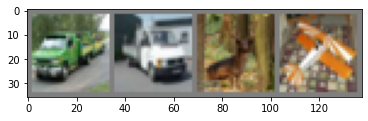

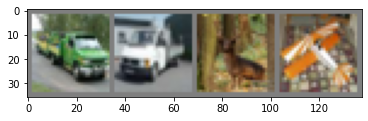

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4835881289006152, train acc: 0.47070465532473715
 val loss: 1.2807436605717273, val acc: 0.5444592199427016

Epoch 1
 train loss: 1.181780092894922, train acc: 0.583691074708698
 val loss: 1.1226184781561506, val acc: 0.6096852837724889

Epoch 2
 train loss: 1.0546927711427538, train acc: 0.6305293484405364
 val loss: 1.04375831928659, val acc: 0.6368794327086591

Epoch 3
 train loss: 0.9978014995672585, train acc: 0.6539484853064557
 val loss: 0.9596221753891478, val acc: 0.6708111702127659

Epoch 4
 train loss: 0.9586726166648446, train acc: 0.6671617915904936
 val loss: 0.9782311327913974, val acc: 0.661192376055616

Epoch 5
 train loss: 0.9230455252762468, train acc: 0.6796528141284991
 val loss: 0.93349868794705, val acc: 0.6732712765957447

Epoch 6
 train loss: 0.905153344056724, train acc: 0.687283722966419
 val loss: 0.9696971104500142, val acc: 0.6619015957446809

Epoch 7
 train 

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.7928734634332596, test acc: 0.7306926751592356


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

### RandomCrop

Будем рандомно кропать изображение, оставляя ~90% от исходного. Нужно ресайзнуть в 32x32, чтобы сетка не сломалась.

In [10]:
transform = transforms.Compose(
        [transforms.RandomCrop(28),
         transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4949468427645878, train acc: 0.4671626077927445
 val loss: 1.3557859141775903, val acc: 0.531781914893617

Epoch 1
 train loss: 1.1789449249586632, train acc: 0.5880084552102377
 val loss: 1.1796099776917315, val acc: 0.5979831561129144

Epoch 2
 train loss: 1.0626469740484052, train acc: 0.631598491773309
 val loss: 1.0200881625743623, val acc: 0.6497562058428501

Epoch 3
 train loss: 1.012064449529979, train acc: 0.6494515539305301
 val loss: 1.0055447723003144, val acc: 0.6501773050490846

Epoch 4
 train loss: 0.9803982972009091, train acc: 0.6583760447214465
 val loss: 0.9594858600738201, val acc: 0.667442376055616

Epoch 5
 train loss: 0.9495074449335199, train acc: 0.6718954035307415
 val loss: 0.9615255979781455, val acc: 0.6664893617021277

Epoch 6
 train loss: 0.918992425558554, train acc: 0.6804403891511112
 val loss: 0.9415857330281684, val acc: 0.6729166667512123

Epoch 7
 train loss: 0.9045638907326204, train acc: 0.6866797793935814
 val loss: 0.9367

In [11]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.832241764873456, test acc: 0.7123805732484076


Вроде неплохо.

### RandomRotation

Случайные повороты.

In [ ]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=30),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6143595440078262, train acc: 0.41770452468007313
 val loss: 1.4352305955075204, val acc: 0.484375

Epoch 1
 train loss: 1.397306087466001, train acc: 0.503142138939671
 val loss: 1.2936160630368172, val acc: 0.5443927305809995

Epoch 2
 train loss: 1.2985478043556213, train acc: 0.5427371703728462
 val loss: 1.2544759697102486, val acc: 0.5585106382978723

Epoch 3
 train loss: 1.2439462503305956, train acc: 0.560884042893293
 val loss: 1.2046887803584971, val acc: 0.5778812057160316

Epoch 4
 train loss: 1.1974318597390838, train acc: 0.5767620463040019
 val loss: 1.2121873726236059, val acc: 0.5758643617021276

Epoch 5
 train loss: 1.1706614426764534, train acc: 0.586372094572789
 val loss: 1.2548086369291265, val acc: 0.5612367021276595

Epoch 6
 train loss: 1.1444327106641459, train acc: 0.5947579329584809
 val loss: 1.1270664993752824, val acc: 0.6008643617021276

Epoch 7
 train loss:

In [ ]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.911637359743665, test acc: 0.6850119426751592


Можно еще поиграться с градусами.

### GaussianBlur

Накладывает случайное размытие фильтром Гаусса.

In [12]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5217404264200758, train acc: 0.45596516720773533
 val loss: 1.2996000333035247, val acc: 0.5397606382978724

Epoch 1
 train loss: 1.2301301230460242, train acc: 0.5650218726294132
 val loss: 1.1565420942103608, val acc: 0.5931072695458189

Epoch 2
 train loss: 1.0976616339230232, train acc: 0.6159653304045989
 val loss: 1.1038041688026266, val acc: 0.6215425531914893

Epoch 3
 train loss: 1.0228204030877275, train acc: 0.6441792896940242
 val loss: 1.0202780492762302, val acc: 0.6449911348363186

Epoch 4
 train loss: 0.9773839179297034, train acc: 0.6591554583753485
 val loss: 0.9909386135162191, val acc: 0.6542553191489362

Epoch 5
 train loss: 0.9474228920186896, train acc: 0.6701692675105833
 val loss: 0.9851649279290057, val acc: 0.6615469859001485

Epoch 6
 train loss: 0.9267644641386308, train acc: 0.6781511165106319
 val loss: 0.9724099334250105, val acc: 0.664472517815042

Epoch 7
 train loss: 0.903506159128611, train acc: 0.6854392465551331
 val loss: 0.

In [13]:
test_loss, test_acc = test(net, test_loader)

print(f"test loss: {test_loss}, test acc: {test_acc}")

test loss: 0.8382488618231123, test acc: 0.7142714968152867


Вроде хорошо получилось.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [21]:
!pip3 install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 166 kB 75.9 MB/s 
     |████████████████████████████████| 182 kB 65.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 166 kB 62.3 MB/s 
     |████████████████████████████████| 162 kB 77.1 MB/s 
     |████████████████████████████████| 162 kB 74.2 MB/s 
     |████████████████████████████████| 158 kB 69.0 MB/s 
     |████████████████████████████████| 157 kB 81.8 MB/s 
     |████████████████████████████████| 157 kB 75.7 MB/s 
     |████████████████████████████████| 157 kB 73.0 MB/s 
     |████████████████████████████████| 157 kB 70.2 MB/s 
     |████████████████████████████████| 157 kB 76.6 MB/s 
     |████████████████████████████████| 157 kB 63.2 MB/s 
     |████████████████████████████████| 157 kB 65.0 MB/s 
     |████████████████████████████

In [22]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
import wandb

wandb.init(project="shw-02-cnn")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kkorolev. Use `wandb login --relogin` to force relogin


In [27]:
def train_with_logger(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        wandb.log({'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc), 'val_loss': val_loss, 'val_acc': val_acc})

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_with_logger(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 0.8269006886146623, train acc: 0.712702402793947
 val loss: 0.9423276203743955, val acc: 0.6775709220703612

Epoch 1
 train loss: 0.8239677589815757, train acc: 0.7143550862777821
 val loss: 0.9289993106050695, val acc: 0.6850177305809995

Epoch 2
 train loss: 0.8122928436757005, train acc: 0.7187948877458381
 val loss: 0.9654546349606615, val acc: 0.6703457446808511

Epoch 3
 train loss: 0.8153006107541282, train acc: 0.716375032661166
 val loss: 0.9629319756589038, val acc: 0.6714539007937654

Epoch 4
 train loss: 0.814054479764628, train acc: 0.7148978193673616
 val loss: 0.9362837180178216, val acc: 0.6755984042553191

Epoch 5
 train loss: 0.8078210578867024, train acc: 0.7177869548963236
 val loss: 0.9200402226853878, val acc: 0.6846409574468085

Epoch 6
 train loss: 0.8029139270185335, train acc: 0.7208923674588665
 val loss: 0.9661635644892429, val acc: 0.673249113559723

Epoch 7
 train loss: 0.8039694446423372, train acc: 0.7211861779310585
 val loss: 1.028

Графики тут

https://wandb.ai/kkorolev/shw-02-cnn?workspace=user-kkorolev